In [1]:
import parse
from learning_curve import *
import numpy as np

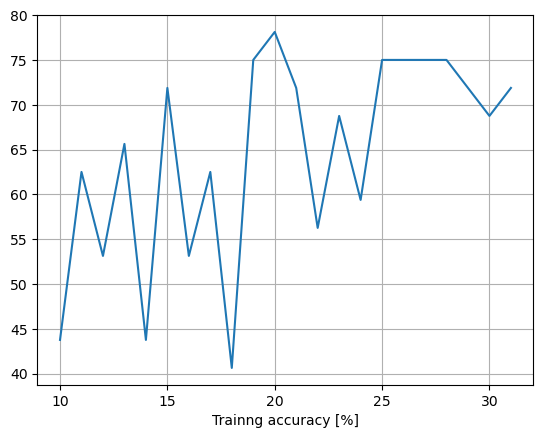

In [2]:
example_size = np.arange(10,32,1)
test_data = parse.parse("cars_test.data")
train_data = parse.parse("cars_train.data")

learn_curve = get_learning_curve_data(examples_sizes=example_size,train_data=train_data,test_data=test_data,default = "unacc")

plot_learning_curve(example_size,learn_curve)